In [1]:
import os
import matplotlib
from math import *
from pandas import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
# sns.set(style="darkgrid")

In [7]:
pcap_file = "./data/pcap/chrome-sat.raw"
csv_file = "./data/pcap/test.csv"
if not os.path.exists(csv_file):
    tshark_cmd = 'tshark -T fields -e _ws.col.No. -e _ws.col.Time -e _ws.col.Source -e _ws.col.Destination -e _ws.col.tls_len -e _ws.col.Info -E header=y -E separator="\t" -E quote=d -E occurrence=f -r {} > {}'.format(pcap_file, csv_file)  
    a = os.system(tshark_cmd)


In [8]:
pcap_main = read_csv(csv_file,sep="\t", index_col=None, encoding='utf-8')
pcap_main.rename(index=str, columns={"_ws.col.No.": "No", "_ws.col.Time": "Time","_ws.col.Source": "Source","_ws.col.Destination": "Destination", "_ws.col.tls_len": "tls_len","_ws.col.Info": "Info"}, inplace=True);
pcap_main.head()

No      Time          Source     Destination tls_len  \
0   1  0.000000   192.168.1.238  172.217.31.202      34   
1   2  0.001367  172.217.31.202   192.168.1.238     NaN   
2   3  0.003434   192.168.1.238  74.125.130.188     553   
3   4  0.008771  54.194.132.188   192.168.1.238     NaN   
4   5  0.010608  54.194.132.188   192.168.1.238      89   

                                                Info  
0                                   Application Data  
1  443 → 53008 [ACK] Seq=1 Ack=40 Win=264 Len=0 T...  
2                                   Application Data  
3  443 → 59350 [ACK] Seq=1 Ack=1 Win=119 Len=0 TS...  
4                                       Server Hello

In [13]:
local_ip = pcap_main['Destination'].value_counts().idxmax()
nf_ip = pcap_main['Source'].value_counts().idxmax()
print(local_ip, nf_ip, sep="\n")

192.168.1.238
45.57.50.133


In [10]:
# Create new data frame to plot the get requests
pcap_get = pcap_main[pcap_main['Destination']== nf_ip]

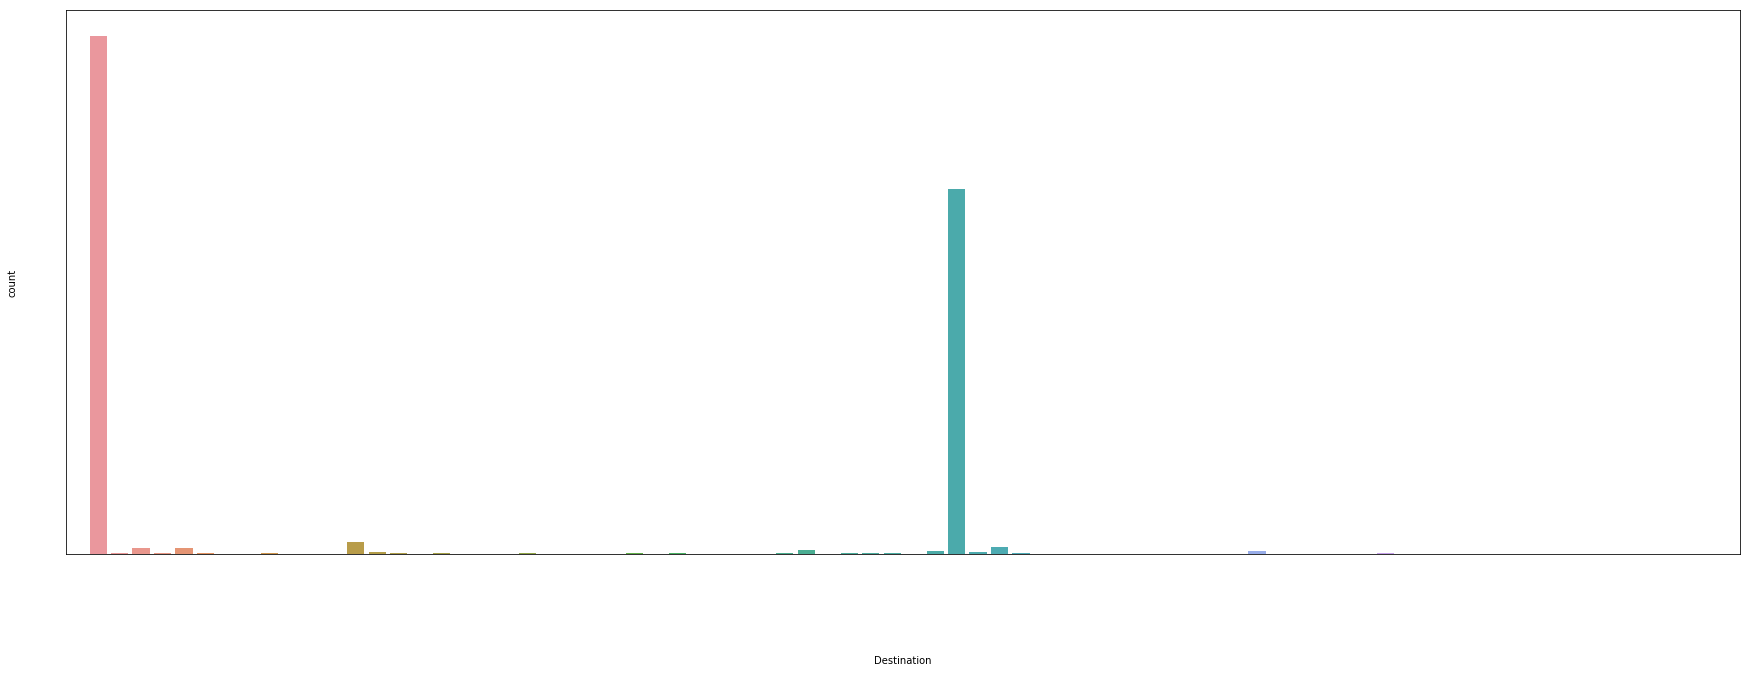

In [11]:
plt.figure(figsize=(30 ,10))
ax = sns.countplot(x="Destination", data=pcap_main)
plt.xticks(rotation=90)
plt.rcParams['xtick.labelsize'] = 15
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

In [14]:
# countng number of packets arived at a particular time (sec)
pkt_cnt = [0] # number of Packets at i'th sec 
d_time = []  # list of time 
start_time = floor(pcap_get.iloc[0,1]) # start time of the first packet in the list

i = 0
d_time.append(start_time)

for _,packet in pcap_get.iterrows():
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        pkt_cnt.append(0)
        d_time.append(curr_time)
        start_time = curr_time
    pkt_cnt[i]+= 1
    

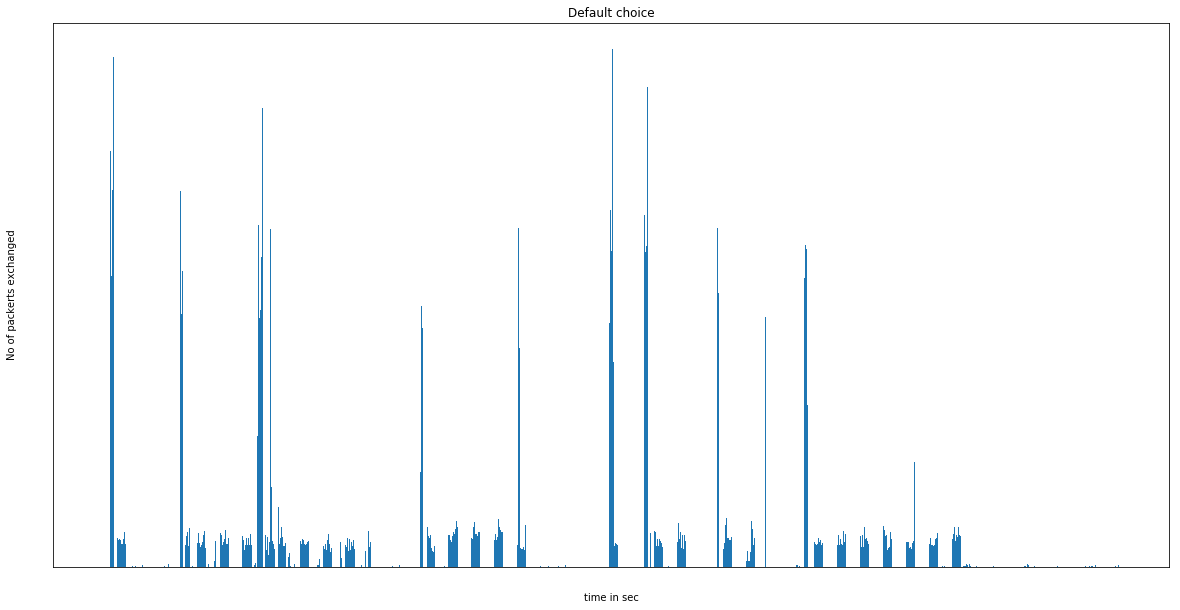

In [15]:
# plotting number of packets vs time
plt.figure(figsize=(20 ,10)) 
plt.bar(d_time, pkt_cnt)
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

In [16]:
# Finding peaks
delta = 0
th = 350
peaks =[] # May contain duplicates
for i in range(1,len(pkt_cnt)):
    delta = pkt_cnt[i]-pkt_cnt[i-1]
    if delta > th:
        startTime = d_time[i]
    elif delta < -th:
        endTime = d_time[i]
        peaks.append([startTime, endTime])
print(peaks)

[[52, 60], [253, 257], [361, 371], [385, 388], [904, 906], [904, 908], [1094, 1102], [1094, 1104], [1136, 1157], [1166, 1168], [1169, 1174], [1256, 1260], [1319, 1322], [1328, 1330], [1420, 1424], [1420, 1426], [1731, 1734]]


In [17]:
# range with no duplicates
f_peaks = [] # Final peaks with hopefuly no duplicates
for i in range(len(peaks)-1):
    if peaks[i][0] != peaks[i+1][0]:
        f_peaks.append(peaks[i])
f_peaks.append(peaks[i+1])

print(f_peaks)

[[52, 60], [253, 257], [361, 371], [385, 388], [904, 908], [1094, 1104], [1136, 1157], [1166, 1168], [1169, 1174], [1256, 1260], [1319, 1322], [1328, 1330], [1420, 1426], [1731, 1734]]


In [18]:
# filling all unknown ssl.record.length with -1
pcap_main.fillna(-1, inplace=True)
pcap_main.head()

No      Time          Source     Destination tls_len  \
0   1  0.000000   192.168.1.238  172.217.31.202      34   
1   2  0.001367  172.217.31.202   192.168.1.238      -1   
2   3  0.003434   192.168.1.238  74.125.130.188     553   
3   4  0.008771  54.194.132.188   192.168.1.238      -1   
4   5  0.010608  54.194.132.188   192.168.1.238      89   

                                                Info  
0                                   Application Data  
1  443 → 53008 [ACK] Seq=1 Ack=40 Win=264 Len=0 T...  
2                                   Application Data  
3  443 → 59350 [ACK] Seq=1 Ack=1 Win=119 Len=0 TS...  
4                                       Server Hello

In [19]:
# filtering out the non application data pakets
temp = pcap_main.query('Info == "Application Data"') # filtering to get only the application data
temp.shape

(11270, 6)

In [20]:
# converting the tls_len to integer type
temp['tls_len'] = temp.tls_len.astype(int, copy=False) # converting the ssllen field to integer type
# filtering to get ssllen in the 6000 to 7000 range.
# temp = temp.query('6000<ssllen<7000')
temp = temp.query('6000<tls_len<7000')


print(temp.shape)
temp.head()

(129, 6)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


No       Time          Source     Destination  tls_len  \
180    181   1.502365  54.194.132.188   192.168.1.238     6512   
5527  5528  36.745587   192.168.1.238  54.194.132.188     6672   
5708  5709  38.546666  54.194.132.188   192.168.1.238     6689   
8208  8209  42.974190    45.57.50.132   192.168.1.238     6262   
8357  8358  43.317532  54.194.132.188   192.168.1.238     6940   

                  Info  
180   Application Data  
5527  Application Data  
5708  Application Data  
8208  Application Data  
8357  Application Data

In [21]:
temp = temp.query('Source == "{}"'.format(local_ip)) # cl2 are sent from client system
print(temp.shape)
temp.head()

(18, 6)


No        Time         Source     Destination  tls_len  \
5527    5528   36.745587  192.168.1.238  54.194.132.188     6672   
14257  14258   53.104820  192.168.1.238  54.194.132.188     6812   
29891  29892   59.974745  192.168.1.238  54.194.132.188     6474   
38713  38714  200.873810  192.168.1.238  54.194.132.188     6661   
51550  51551  255.926876  192.168.1.238  54.194.132.188     6651   

                   Info  
5527   Application Data  
14257  Application Data  
29891  Application Data  
38713  Application Data  
51550  Application Data

In [22]:
# find all packets that looks like data-cl2
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = floor(temp.iloc[0,1])

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No'])
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['tls_len']/10
    
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

cl2 length: [667.2, 681.2, 647.4, 666.1, 665.1, 646.9, 621.8, 635.8, 611.0, 619.2, 659.8, 649.7, 647.4, 652.2, 642.0, 665.9, 646.5, 649.3] 
cl2 occurance time: [36, 53, 59, 200, 255, 362, 373, 386, 699, 704, 767, 908, 1112, 1140, 1255, 1323, 1490, 1735]


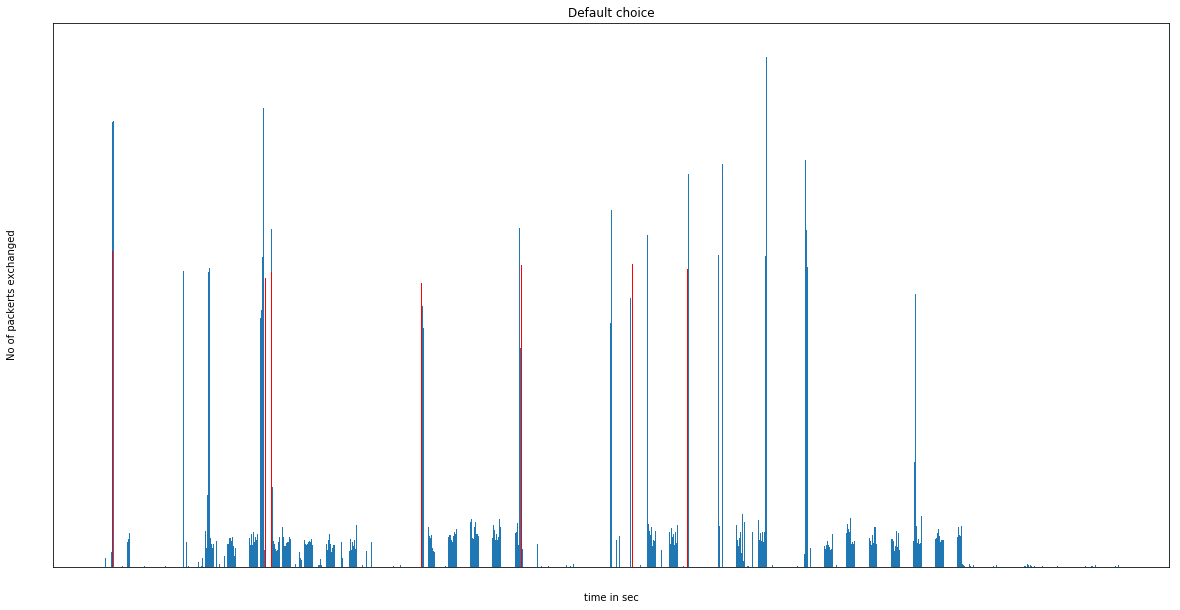

In [23]:
# plot the data-cl2 along with all the pakets
plt.figure(figsize=(20,10))
plt.bar(d_time, pkt_cnt)
plt.bar(cl2_time, cl2_cnt, color = 'red')
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()


In [32]:
# [{'time':x, 'frame_no':y } for x, y in zip(d,f_no)]

In [33]:
# filter out all the packets which are not near the peaks
final = []
for i in range(len(cl2_time)):
#     print("processing : {}".format(d[i]))
    for peak in f_peaks:
        if cl2_time[i]>= peak[0] and cl2_time[i]<=peak[-1]+2:
#             print("found in range : {}".format(peak))
            final.append(cl2_time[i])
#         else:
#             print("not found in any range") # debug

In [34]:
# comparing the filtered and non-filtered cl2's
print("using only length filter: {} \nfinal cl2's: {}".format(cl2_time, final))

using only length filter: [3, 8, 25, 164, 222, 500, 816, 848, 917] 
final cl2's: [25, 164, 222, 500, 816, 848, 917]


In [35]:
# getting more details about the cl2's
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = temp.iloc[0,1]

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No'])
    curr_time = packet.Time
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['tls_len']
    
# printing the result
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

In [37]:
ll = [[x,y] for x, y in zip(cl2_time,f_no)]
print(ll)

[[3.435062504, 443], [8.462796786, 10048], [8.682668236, 10121], [25.116945629, 34576], [164.263293638, 44989], [222.59469943099998, 57799], [500.74495569, 80248], [816.3154149610001, 102252], [848.046948384, 118260], [917.531750925, 137040]]


In [38]:
# filtering the cl2's if not near peak
final_cl2 = []
for l in ll:
#     print("processing : {}".format(l))
    for peak in f_peaks:
        if l[0]>= peak[0] and l[0]<=peak[-1]+2:
            final_cl2.append(l)
            
print(final_cl2)

[[25.116945629, 34576], [164.263293638, 44989], [222.59469943099998, 57799], [500.74495569, 80248], [816.3154149610001, 102252], [848.046948384, 118260], [917.531750925, 137040]]
